In [1]:
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
import sys
from scipy.stats import linregress

fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

2023-10-13 10:08:57.080149: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 10:08:57.082031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 10:08:57.116063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 10:08:57.116123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 10:08:57.116149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

/tmp/ipykernel_18486/3886661535.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]]))


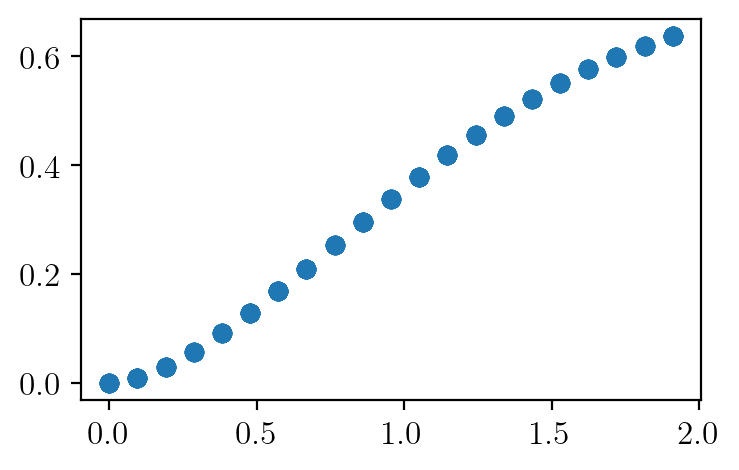

In [2]:
def circuit(alpha):
    q = QuantumRegister(3,'q')
    circuit = QuantumCircuit(q)
    circuit.ry(alpha, q[0])
    circuit.ch(q[0],q[1])
    circuit.cnot(q[1],q[2])
    circuit.cnot(q[0],q[1])
    circuit.x(q[0])
    return circuit

def get_dm(alpha):
    state = Statevector.from_int(0, 2**3)
    state = state.evolve(circuit(alpha))
    return DensityMatrix(state)

def get_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm):
    UaUb = qt.Qobj(
        np.kron(
            np.kron(get_u(2),get_u(2)),get_u(2) )
    ,dims = [[2, 2, 2], [2, 2, 2]])
    return  UaUb.dag() * dm * UaUb 

n_points = 21
n_samples = 50
scan_arr = np.linspace(0,2*np.arccos(1/np.sqrt(3)),n_points)
rho_arr_noisy = np.zeros((n_points,n_samples,8,8))
neg_arr = np.zeros((n_points,n_samples))

for i, theta in enumerate(scan_arr):   
        
    dm = get_dm(theta) 
    
    for inx, s in enumerate(range(n_samples)):
        rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]]))
        state = apply_u( qt.Qobj(dm.data,dims=[[2,2,2],[2,2,2]])) 
        neg_arr[i,inx] = qt.entropy_vn(qt.ptrace(state,[1,2]))
            
rho_arr_noisy = np.reshape(rho_arr_noisy,(n_points*n_samples,64))
neg_arr = np.reshape(neg_arr,(n_points*n_samples))


alpha_arr = np.zeros(len(rho_arr_noisy))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1

X_train, X_test, y_train, y_test, neg_train, neg_test = train_test_split(rho_arr_noisy, alpha_arr, neg_arr, random_state=42)


plt.scatter(y_test, neg_test)

In [3]:
def beta_sched(n_iter, start=0.0, stop=1.0,  n_cycle=1, ratio=0.8):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v#np.sin(3*i/period)       
            v += step
            i += 1
    return L 

# plt.plot(0.25*beta_sched(80000))

In [4]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a p-vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

epochs = 100
batch_size = 256

lr_sched = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=epochs*int(len(X_train)/batch_size),
    alpha=0.0001/0.001,
    warmup_steps=0,
    )

class LVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(LVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 0
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched)

    def call(self,data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction


def vae_mlp_8x8(latent_dim_1, latent_dim_2, latent_dim_3, act_func, f_act):
    encoder_inputs = tf.keras.Input(shape=64)
    x = encoder_inputs
    h1 = tf.keras.layers.Dense(64, activation=act_func)(x)
    h2 = tf.keras.layers.Dense(48, activation=act_func)(h1)
    h3 = tf.keras.layers.Dense(32, activation=act_func)(h2)

    z_mean_1 = tf.keras.layers.Dense(latent_dim_1, name="z_mean_1", activation="linear")(h1)
    z_log_var_1 = tf.keras.layers.Dense(latent_dim_1, name="z_log_var_1")(h1)
    z_1 = Sampling()([z_mean_1, z_log_var_1])

    z_mean_2 = tf.keras.layers.Dense(latent_dim_2, name="z_mean_2", activation="linear")(h2)
    z_log_var_2 = tf.keras.layers.Dense(latent_dim_2, name="z_log_var_2")(h2)
    z_2 = Sampling()([z_mean_2, z_log_var_2])

    z_mean_3 = tf.keras.layers.Dense(latent_dim_3, name="z_mean_3", activation="linear")(h3)
    z_log_var_3 = tf.keras.layers.Dense(latent_dim_3, name="z_log_var_3")(h3)
    z_3 = Sampling()([z_mean_3, z_log_var_3])
    
    encoder = tf.keras.Model(encoder_inputs, [z_mean_1, z_log_var_1, z_1, z_mean_2, z_log_var_2, z_2, z_mean_3, z_log_var_3, z_3], name="encoder")
    
    z_1_input, z_2_input, z_3_input = tf.keras.Input(shape=(latent_dim_1,)), tf.keras.Input(shape=(latent_dim_2,)), tf.keras.Input(shape=(latent_dim_3,))
    
    z_3 = tf.keras.layers.Dense(latent_dim_3)(z_3_input)
    z_tilde_3_layers = tf.keras.Sequential([tf.keras.layers.Dense(latent_dim_3)] * 2, name='z_tilde_3')
    z_tilde_3 = z_tilde_3_layers(z_3)
        
    z_2 = tf.keras.layers.Dense(latent_dim_2)(z_2_input)
    z_tilde_2_layers = tf.keras.Sequential([tf.keras.layers.Dense(latent_dim_2)] * 2, name='z_tilde_2')
    input_z_tilde_2 = tf.keras.layers.Concatenate()([z_tilde_3, z_2])
    z_tilde_2 = z_tilde_2_layers(input_z_tilde_2)
    
    
    z_1 = tf.keras.layers.Dense(latent_dim_1)(z_1_input)
    z_tilde_1_layers =  tf.keras.Sequential([tf.keras.layers.Dense(latent_dim_1)] * 2, name='z_tilde_1')
    input_z_tilde_1 = tf.keras.layers.Concatenate()([z_tilde_2, z_1])
    z_tilde_1 = z_tilde_1_layers(input_z_tilde_1)
        
    decoder = tf.keras.layers.Dense(32, activation=act_func)(z_tilde_1)
    decoder = tf.keras.layers.Dense(48, activation=act_func)(decoder)
    decoder = tf.keras.layers.Dense(64, activation=act_func)(decoder)

    decoder_outputs = tf.keras.layers.Dense(64, activation=f_act)(decoder)
    decoder = tf.keras.Model([z_1_input, z_2_input, z_3_input], decoder_outputs, name="decoder")

    return encoder, decoder

encoder, decoder = vae_mlp_8x8(16,8,4, "tanh", "linear")
vae_test = LVAE(encoder, decoder)

loss_arr = np.zeros(epochs)
rc_loss_arr =  np.zeros(epochs)
kl_loss_arr = np.zeros(epochs)

@tf.function
def train_step(data, beta_1, beta_2, beta_3):
        
        with tf.GradientTape() as tape:
            z_mean_1, z_log_var_1, z_1, z_mean_2, z_log_var_2, z_2, z_mean_3, z_log_var_3, z_3 = vae_test.encoder(data)
            reconstruction = vae_test.decoder([z_1,z_2,z_3])
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=-1))
            
            kl_loss_1 = -0.5 * (1 + z_log_var_1 - tf.square(z_mean_1) - tf.exp(z_log_var_1))
            kl_loss_1 = tf.reduce_mean(tf.reduce_sum(kl_loss_1, axis=1))

            kl_loss_2 = -0.5 * (1 + z_log_var_2 - tf.square(z_mean_2) - tf.exp(z_log_var_2))
            kl_loss_2 = tf.reduce_mean(tf.reduce_sum(kl_loss_2, axis=1))

            kl_loss_3 = -0.5 * (1 + z_log_var_3 - tf.square(z_mean_3) - tf.exp(z_log_var_3))
            kl_loss_3 = tf.reduce_mean(tf.reduce_sum(kl_loss_3, axis=1))
            
            kl_loss = beta_1 * kl_loss_1 + beta_2 * kl_loss_2 + beta_3 * kl_loss_3

            total_loss = reconstruction_loss +  kl_loss
        grads = tape.gradient(total_loss, vae_test.trainable_weights)
        vae_test.optimizer.apply_gradients(zip(grads, vae_test.trainable_weights))
     
        return total_loss, reconstruction_loss, kl_loss

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

final_beta = 0.4
beta_arr =  final_beta*np.array(beta_sched(epochs))
plot = False

loss_arr = np.zeros(epochs)
rc_loss_arr =  np.zeros(epochs)
kl_loss_arr = np.zeros(epochs)

for epoch in range(epochs):
    beta = beta_arr[epoch] 
    
    for step, batch_data in enumerate(dataset):
        loss, rc_loss, kl_loss = train_step(batch_data,np.float32(beta/1),np.float32(beta/1),np.float32(beta))

        loss_arr[epoch] = loss
        rc_loss_arr[epoch] = rc_loss
        kl_loss_arr[epoch] = kl_loss

    if epoch > 100 and kl_loss < 10e-3:
        print("KL Vanishing")
        break

    if plot and epoch % 1000 == 0 :
        z_mean_1, _, _,z_mean_2, _, _,z_mean_3, _, _ = vae_test.encoder.predict(X_test)

        tsne = TSNE()
        fix, axs = plt.subplots(1,3)

        a = tsne.fit_transform(z_mean_1) 
        b = tsne.fit_transform(z_mean_2) 
        c = tsne.fit_transform(z_mean_3) 
        axs[0].scatter(a[:,0],a[:,1],c=y_test)
        axs[1].scatter(b[:,0],b[:,1],c=y_test)
        axs[2].scatter(c[:,0],c[:,1],c=y_test)

        plt.tight_layout()
        plt.savefig("test{}.png".format(str(epoch)))

        

9/9 [==============================] - 0s 1ms/step


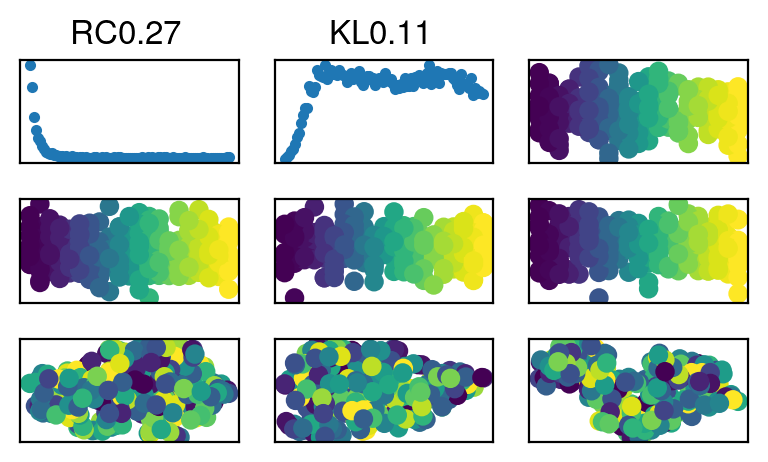

In [5]:
z_mean_1, _, _,z_mean_2, _, _,z_mean_3, _, _ = vae_test.encoder.predict(X_test)

tsne = TSNE()
a = tsne.fit_transform(z_mean_1) 
b = tsne.fit_transform(z_mean_2) 
c = tsne.fit_transform(z_mean_3)

fix, axs = plt.subplots(3,3)

axs[0,0].plot(rc_loss_arr,".")
axs[0,1].plot(kl_loss_arr,".")

axs[0,0].set_title("RC"+str(np.round(rc_loss_arr[-1],2)))
axs[0,1].set_title("KL"+str(np.round(kl_loss_arr[-1],2)))

axs[0,2].scatter(y_test,z_mean_3[:,0],c=neg_test)
axs[1,0].scatter(y_test,z_mean_3[:,1],c=neg_test)
axs[1,1].scatter(y_test,z_mean_3[:,2],c=neg_test)
axs[1,2].scatter(y_test,z_mean_3[:,3],c=neg_test)


axs[2,0].scatter(a[:,0],a[:,1],c=y_test)
axs[2,1].scatter(b[:,0],b[:,1],c=y_test)
axs[2,2].scatter(c[:,0],c[:,1],c=y_test)

for ax in axs:
    for aa in ax:
        aa.set_xticks([])
        aa.set_yticks([])

plt.tight_layout()


9/9 [==============================] - 0s 1ms/step


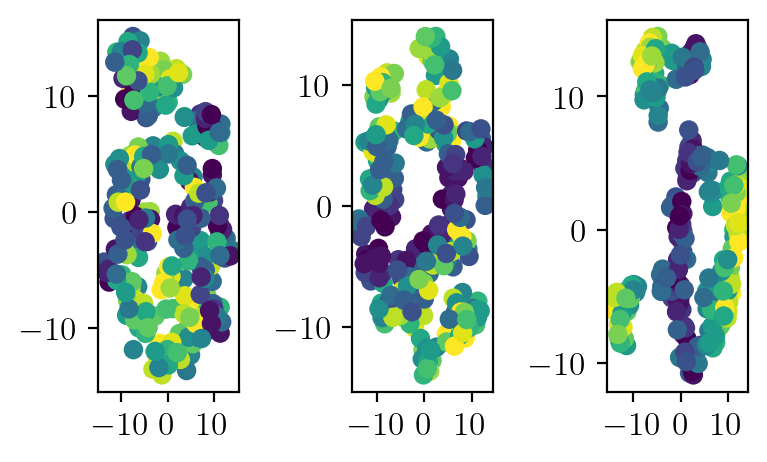

In [6]:
en,de  = vae_mlp_8x8(16,8,4, "tanh", "linear")

en.load_weights("/home/felix/Downloads/vary_beta/test/en_3_model.h5") 
de.load_weights("/home/felix/Downloads/vary_beta/test/de_3_model.h5")
vae_load = LVAE(en, de)

vae_load.optimizer = tf.keras.optimizers.Adam(learning_rate=0)

@tf.function
def train_step(data, beta_1, beta_2, beta_3):
        
        with tf.GradientTape() as tape:
            z_mean_1, z_log_var_1, z_1, z_mean_2, z_log_var_2, z_2, z_mean_3, z_log_var_3, z_3 = vae_load.encoder(data)
            reconstruction = vae_load.decoder([z_1,z_2,z_3])
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=-1))
            
            kl_loss_1 = -0.5 * (1 + z_log_var_1 - tf.square(z_mean_1) - tf.exp(z_log_var_1))
            kl_loss_1 = tf.reduce_mean(tf.reduce_sum(kl_loss_1, axis=1))

            kl_loss_2 = -0.5 * (1 + z_log_var_2 - tf.square(z_mean_2) - tf.exp(z_log_var_2))
            kl_loss_2 = tf.reduce_mean(tf.reduce_sum(kl_loss_2, axis=1))

            kl_loss_3 = -0.5 * (1 + z_log_var_3 - tf.square(z_mean_3) - tf.exp(z_log_var_3))
            kl_loss_3 = tf.reduce_mean(tf.reduce_sum(kl_loss_3, axis=1))
            
            kl_loss = beta_1 * kl_loss_1 + beta_2 * kl_loss_2 + beta_3 * kl_loss_3

            total_loss = reconstruction_loss +  kl_loss
        grads = tape.gradient(total_loss, vae_load.trainable_weights)
        vae_load.optimizer.apply_gradients(zip(grads, vae_load.trainable_weights))
     
        return total_loss, reconstruction_loss, kl_loss

dataset = tf.data.Dataset.from_tensor_slices(X_test)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

final_beta = 0.35

for step, batch_data in enumerate(dataset):
    loss, rc_loss, kl_loss = train_step(batch_data,np.float32(final_beta/1),np.float32(final_beta/1),np.float32(final_beta))
    break
        
z_mean_1, _, _,z_mean_2, _, _,z_mean_3, _, _ = vae_load.encoder.predict(X_test)

tsne = TSNE()
fix, axs = plt.subplots(1,3)

a = tsne.fit_transform(z_mean_1) 
b = tsne.fit_transform(z_mean_2) 
c = tsne.fit_transform(z_mean_3) 
axs[0].scatter(a[:,0],a[:,1],c=y_test)
axs[1].scatter(b[:,0],b[:,1],c=y_test)
axs[2].scatter(c[:,0],c[:,1],c=y_test)

plt.tight_layout()

LinregressResult(slope=2.394579328172239, intercept=-0.03884615685282844, rvalue=0.9617292584275847, pvalue=9.19481825678196e-149, stderr=0.04222883693165166, intercept_stderr=0.016040148527973357)

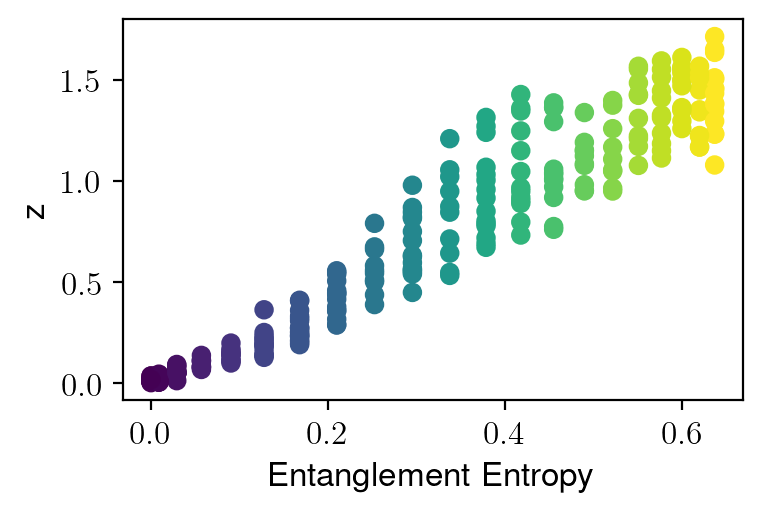

In [8]:
state_arr = [ qt.Qobj(np.reshape(q,(8,8)),dims=[[2,2,2],[2,2,2]]) for q in X_test]

neg_test = [qt.entropy_vn(qt.ptrace(state,[0,2])) for state in state_arr]


plt.scatter(neg_test,np.abs(z_mean_3[:,3]),c=neg_test)
plt.xlabel("Entanglement Entropy")
plt.ylabel("z")
linregress(neg_test,np.abs(z_mean_3[:,3]))
